# TP 3 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [257]:
import sys
sys.path.append("D:/ITBA-2022-Q2/Imag/Imagenes-GIT/Digital-Image-Processing/")
from common.functions import *

In [258]:
from functions import *

In [259]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***

![ej1](img/consigna_1.png)

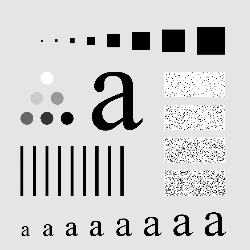

In [260]:
a = cv2.imread('img/a.tif', cv2.IMREAD_GRAYSCALE)
w, h = (500, 500)
a = cv2.resize(a, (w, h), cv2.INTER_NEAREST)
displayImage_fromcv2(a, w//2, h//2)

Aplicando los kernels de tamaño $n\times n$ del tipo
\begin{equation}
    w = \frac{1}{n^2}
    \begin{bmatrix}
    1 & 1 & ... & 1 \\
    1 & 1 & ... & 1 \\
    . & . & ... & . \\
    . & . & ... & . \\
    1 & 1 & ... & 1
    \end{bmatrix}
\end{equation}

In [261]:
window_sizes = [3,5,9,15,25,35,45,55]
a_comparison = a.copy()
for n in window_sizes:
    filtered_image = lowpass_unit_kernel(img=a, n=n)
    a_comparison = np.concatenate((a_comparison, filtered_image), axis=1)


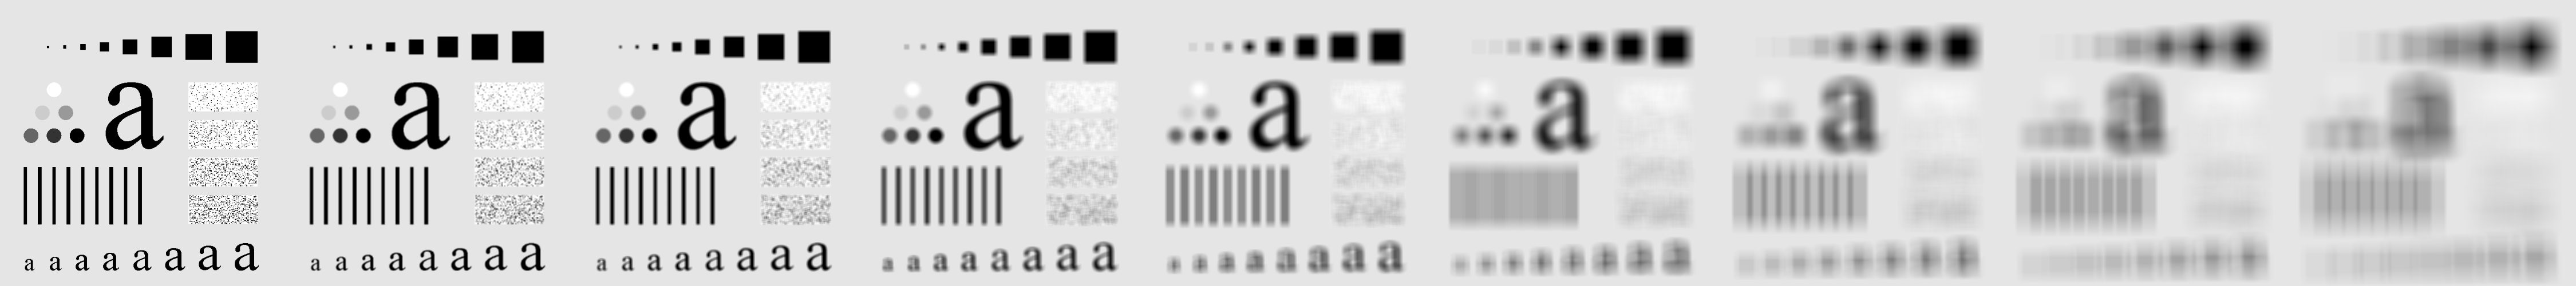

In [262]:
disp_img = Image.fromarray(a_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

***

![ej2](img/consigna_2.png)

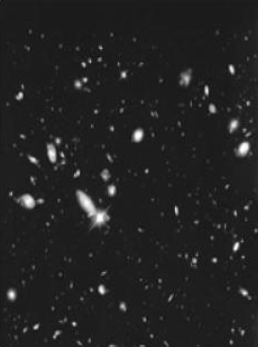

In [263]:
stars = cv2.imread('img/stars.png', cv2.IMREAD_GRAYSCALE)
h, w = stars.shape
displayImage_fromcv2(stars, w//3, h//3)

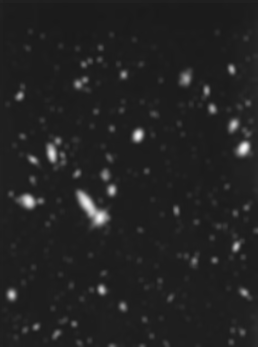

In [264]:
stars_filtered = lowpass_unit_kernel(img=stars, n=15)
displayImage_fromcv2(stars_filtered, w//3, h//3)

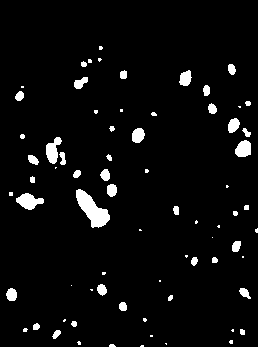

In [265]:
threshold = 0.25*np.max(stars_filtered)
stars_threshold = binary_mask(img=stars_filtered, threshold=threshold)
displayImage_fromcv2(stars_threshold, w//3, h//3)

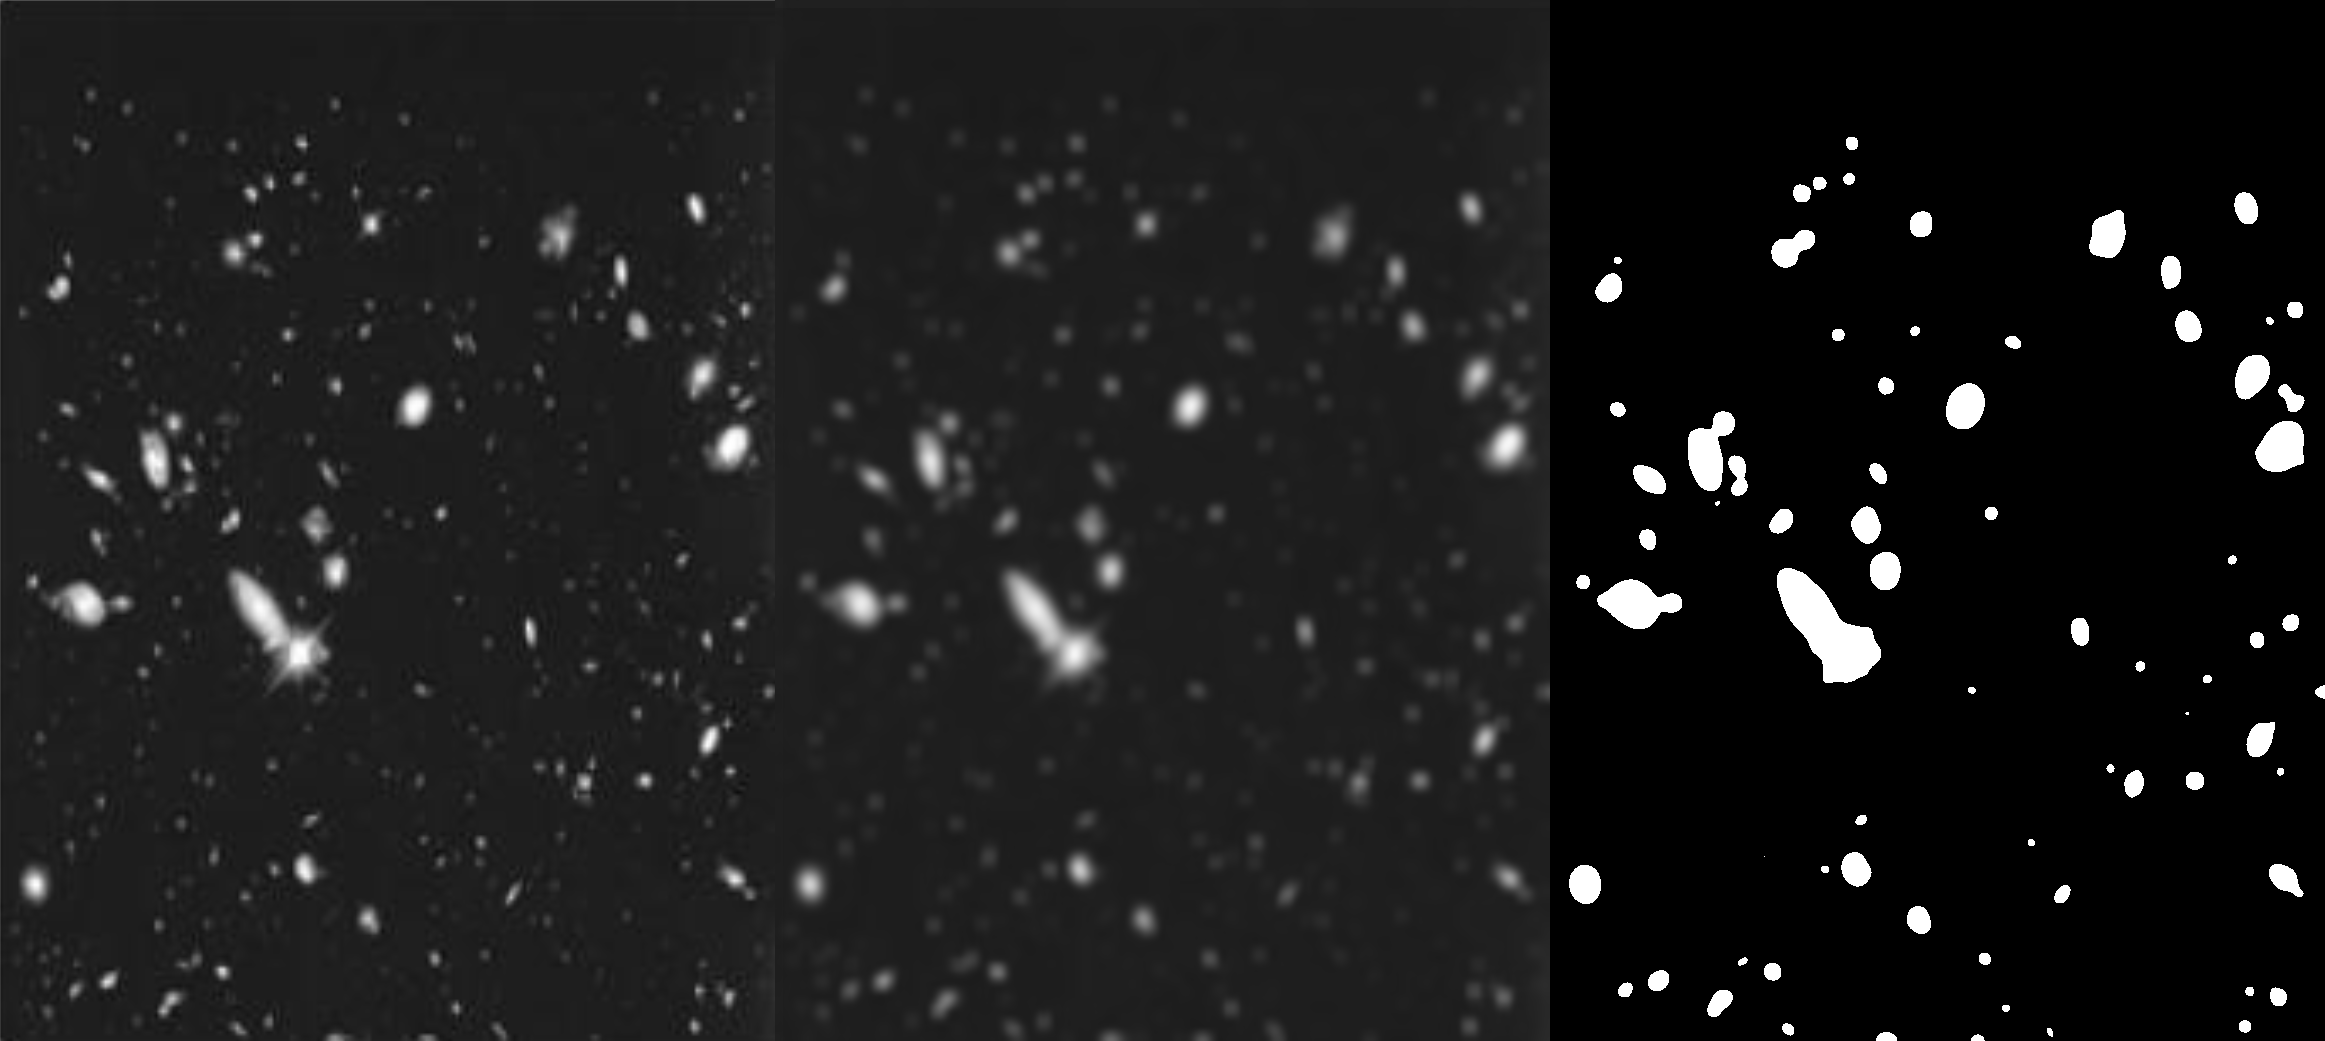

In [266]:
stars_comparison = np.concatenate((stars, stars_filtered, stars_threshold), axis=1)
displayImage_fromcv2(stars_comparison, w*3, h)

***

![ej3](img/consigna_3.png)

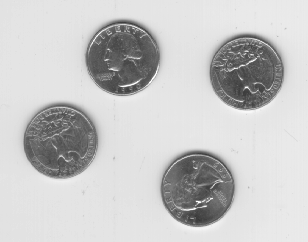

In [267]:
coins = cv2.imread('img/eight.tif', cv2.IMREAD_GRAYSCALE)
h, w = coins.shape
displayImage_fromcv2(coins, w, h)

Agregamos ruido "Salt & Pepper"

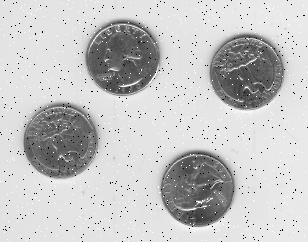

In [268]:
coins_sp = salt_and_pepper_noise(img=coins, d=0.02)
h, w = coins_sp.shape
displayImage_fromcv2(coins_sp, w, h)

Filtrado con pasa bajos

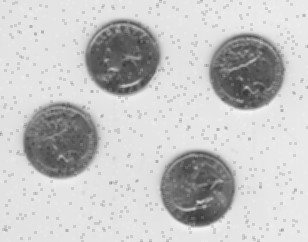

In [269]:
coins_filtered_lp = lowpass_unit_kernel(img=coins_sp, n=3)
displayImage_fromcv2(coins_filtered_lp, w, h)

Aplicando un filtro de mediana a la imagen con ruido sin LP

El filtro de mediana toma la ventana de vecinos de cada pixel, ordena su valor de gris de menor a mayor, y reemplaza el valor del pixel por el valor central del arreglo (si tiene una cantidad impar de elementos), o el promedio de los dos valores centrales (si tiene una cantidad par).

Esto efectivamente elimina los pixeles con valores "outliers" generados por el Salt and Pepper, ya que la probabilidad de que 0 o 255 sean elegidos como el nuevo valor de gris es prácticamente nula.

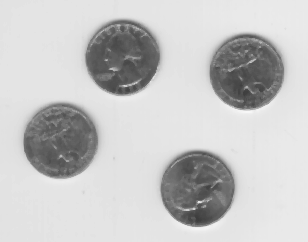

In [270]:
coins_filtered_median = cv2.medianBlur(coins_sp, 3)
displayImage_fromcv2(coins_filtered_median, w, h)

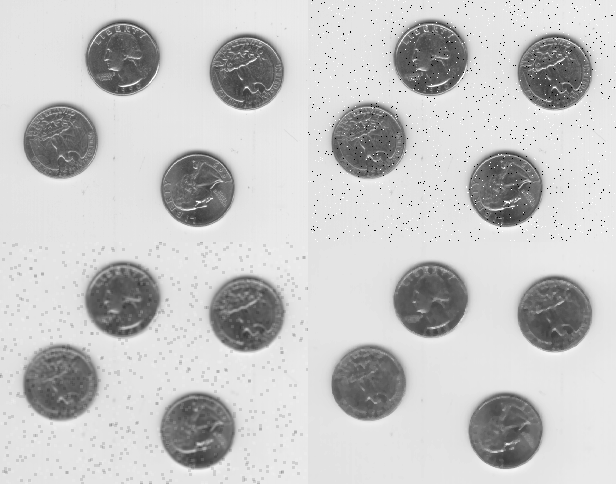

In [271]:
coins_comparison_h = np.concatenate((coins, coins_sp), axis=1)
coins_comparison_l = np.concatenate((coins_filtered_lp, coins_filtered_median), axis=1)
coins_comparison = np.concatenate((coins_comparison_h, coins_comparison_l))
displayImage_fromcv2(coins_comparison, w*2, h*2)

***

### 4. Uso del laplaciano para la recuperación del fondo sin perder la información de los bordes

Comentario: pude replicar el resultado con el kernel directo, pero todavía no con los pasos intermedios.

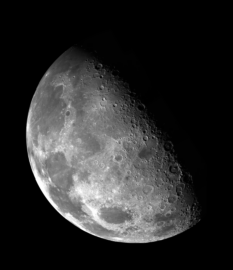

In [272]:
moon = cv2.imread('img/blurry_moon.tif', cv2.IMREAD_GRAYSCALE)
h, w = moon.shape
displayImage_fromcv2(moon, w//2, h//2)

Obteniendo el laplaciano, incluyendo diagonales con un kernel del tipo
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 8 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

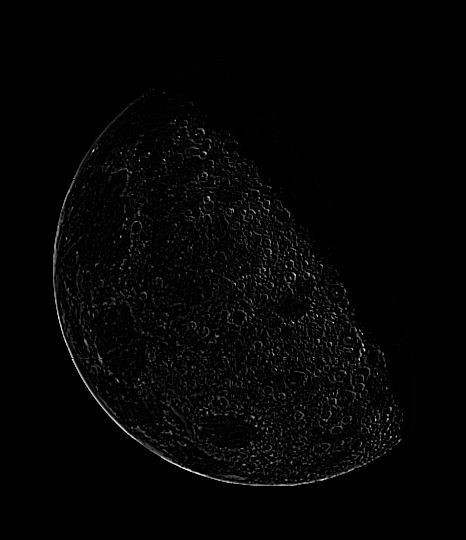

In [273]:
n = 3
kernel = np.ones((n,n))*(-1)
kernel[n//2,n//2] = 8
moon_laplacian = filter2D(src=moon, ddepth=-1, kernel=kernel)
displayImage_fromcv2(moon_laplacian, w, h)

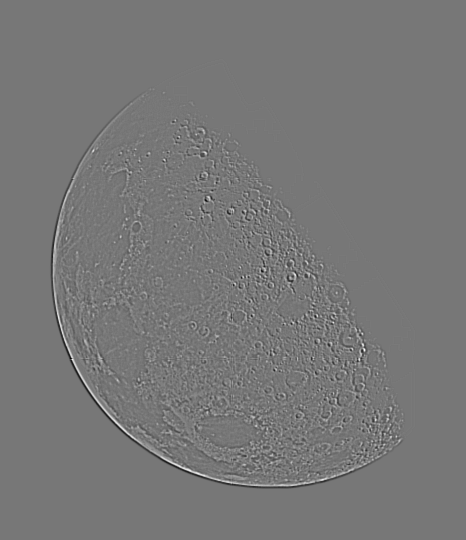

In [274]:
moon_f   = (moon - np.amin(moon))*255.0/(np.amax(moon)) 
moon_laplacian = filter2D(src=moon_f, ddepth=-1, kernel=kernel)
moon_laplacian = moon_laplacian-np.amin(moon_laplacian)
moon_laplacian_scaled = moon_laplacian*255.0/np.amax(moon_laplacian)
displayImage_fromcv2(moon_laplacian_scaled, w, h)

Sumando laplaciano y fondo con un kernel del tipo en la imagen original
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 9 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

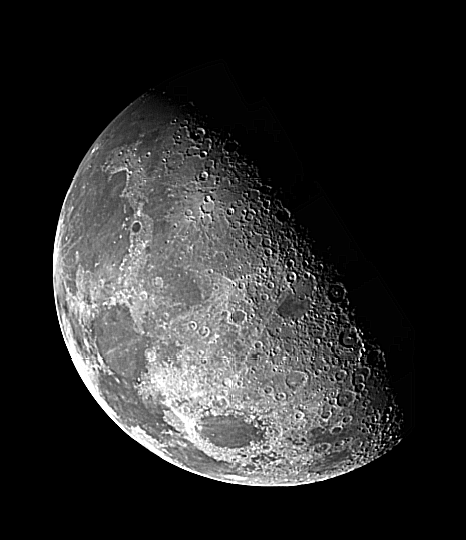

In [275]:
n = 3
kernel = np.ones((n,n))*(-1)
kernel[n//2,n//2] = 9
moon_filtered = filter2D(src=moon, ddepth=-1, kernel=kernel)
displayImage_fromcv2(moon_filtered, w, h)

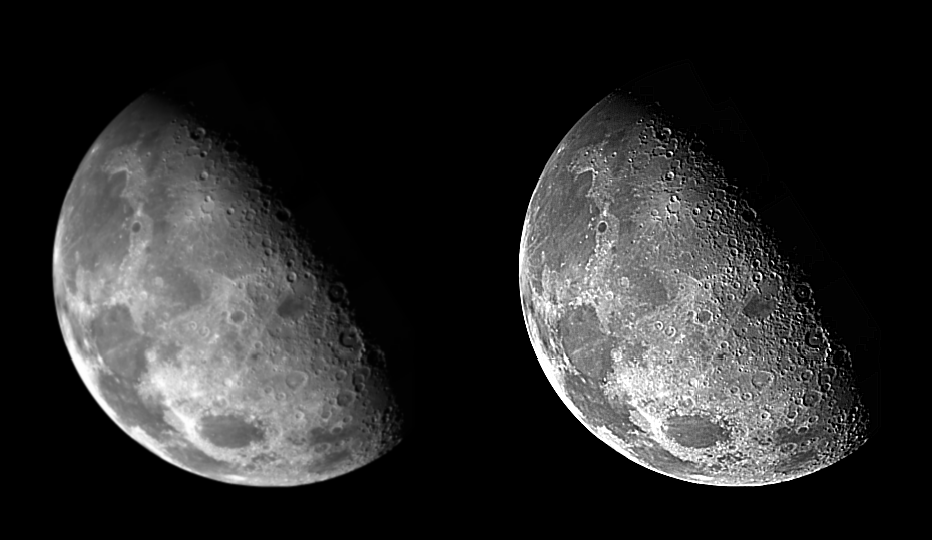

In [276]:
moon_comparison = np.concatenate((moon, moon_filtered), axis=1)
displayImage_fromcv2(moon_comparison, w*2, h)

***

### 5. High Boost

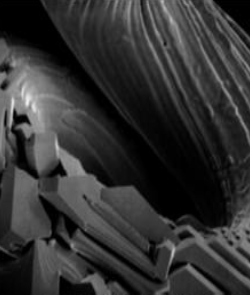

In [277]:
image_dark = cv2.imread('img/dark_img.png', cv2.IMREAD_GRAYSCALE)
h, w = image_dark.shape
displayImage_fromcv2(image_dark, w, h)

Aplicando el High Boost se usa el siguiente kernel
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & A+8 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

Original:			A: 0				A: 1				A: 1.7				

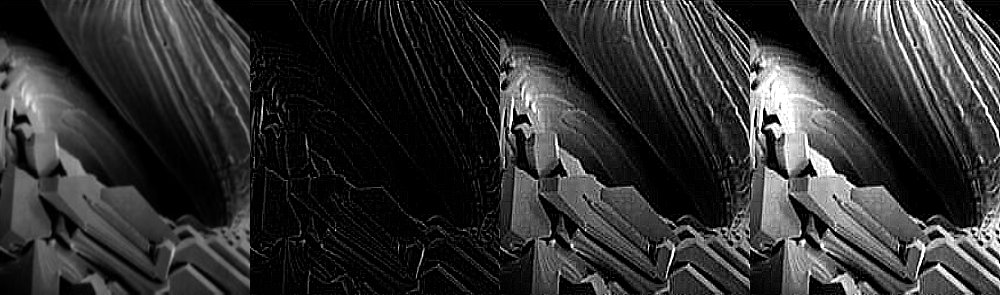

In [278]:
HB_comparison = image_dark
print("Original:",end='\t\t\t')
for A in [0,1,1.7]:
    HB_comparison = np.concatenate((HB_comparison, HB_Filter(A=A,img=image_dark)), axis=1)
    print("A:",A,end='\t\t\t\t')
disp_img = Image.fromarray(HB_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

***

![ej6](img/consigna_6.png)

***

### 7. Dada la imagen lena.tif se pide obtener (usando imadjust): 
* El negativo de la imagen 
* Implementar una transformación tal que convierta los valores entre [0.25 0.5] al rango [0 1]

***

![ej8](img/consigna_8.png)

***

### 9. Realizar la medición de al menos 2 monitores (Laptop-PC) de la corrección gamma usando el fotómetro provisto por la catedra.